In [ ]:
import keras
from keras.datasets import cifar100
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Flatten
from keras.layers import Conv2D, MaxPool2D
from keras import optimizers
import numpy as np

In [ ]:
batch_size = 128

(x_train, y_train), (x_test, y_test) = cifar100.load_data()
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

169009152/169001437 [==============================] - 8s 0us/step


In [ ]:
def normalize(x):
  mean = np.mean(x, axis = (0, 1, 2, 3))
  std = np.std(x, axis = (0, 1, 2, 3))
  print(mean)
  print(std)
  x = (x - mean) / std
  return x

x_train = normalize(x_train)
x_test = normalize(x_test)

121.93584
68.38902
122.241035
68.63058


In [ ]:
from sklearn.model_selection import train_test_split
x_test, x_val, y_test, y_val = train_test_split(x_test, y_test, test_size = 0.5, random_state = 42)

In [ ]:
y_train1 = keras.utils.to_categorical(y_train, 100)
y_test1 = keras.utils.to_categorical(y_test, 100)
y_val1 = keras.utils.to_categorical(y_val, 100)

In [ ]:
# Ref: https://github.com/geifmany/cifar-vgg/blob/master/cifar100vgg.py
model = Sequential()
model.add(Conv2D(input_shape = (32, 32, 3),filters = 64, kernel_size = (3, 3), padding = "same", activation= "elu"))
model.add(Conv2D(filters = 64, kernel_size = (3,3), padding = "same", activation = "elu"))
model.add(MaxPool2D(pool_size = (2, 2), strides = (2, 2)))
model.add(Conv2D(filters = 128, kernel_size = (3, 3), padding = "same", activation = "elu"))
model.add(Conv2D(filters = 128, kernel_size = (3, 3), padding = "same", activation = "elu"))
model.add(MaxPool2D(pool_size = (2, 2), strides = (2, 2)))
model.add(Conv2D(filters = 256, kernel_size = (3, 3), padding = "same", activation = "elu"))
model.add(Conv2D(filters = 256, kernel_size = (3, 3), padding = "same", activation = "elu"))
model.add(Conv2D(filters = 256, kernel_size = (3, 3), padding = "same", activation = "elu"))
model.add(MaxPool2D(pool_size = (2, 2), strides = (2, 2)))
model.add(Conv2D(filters = 512, kernel_size = (3, 3), padding = "same", activation = "elu"))
model.add(Conv2D(filters = 512, kernel_size = (3, 3), padding = "same", activation = "elu"))
model.add(Conv2D(filters = 512, kernel_size = (3, 3), padding = "same", activation = "elu"))
model.add(MaxPool2D(pool_size = (2, 2), strides = (2, 2)))
model.add(Conv2D(filters = 512, kernel_size = (3, 3), padding = "same", activation = "elu"))
model.add(Conv2D(filters = 512, kernel_size = (3, 3), padding = "same", activation = "elu"))
model.add(Conv2D(filters = 512, kernel_size = (3, 3), padding = "same", activation = "elu"))
model.add(MaxPool2D(pool_size = (2, 2), strides = (2, 2)))

model.add(Flatten())
model.add(Dense(units = 4096, activation = "elu"))
model.add(Dense(units = 4096, activation = "relu"))
model.add(Dense(units = 100, activation = "softmax"))

In [ ]:
opt = optimizers.SGD(learning_rate = 0.1)
model.compile(optimizer = opt, loss = keras.losses.categorical_crossentropy, metrics = ['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 64)        1792      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 64)        36928     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 128)       73856     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 128)       147584    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 8, 128)         0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 8, 8, 256)         2

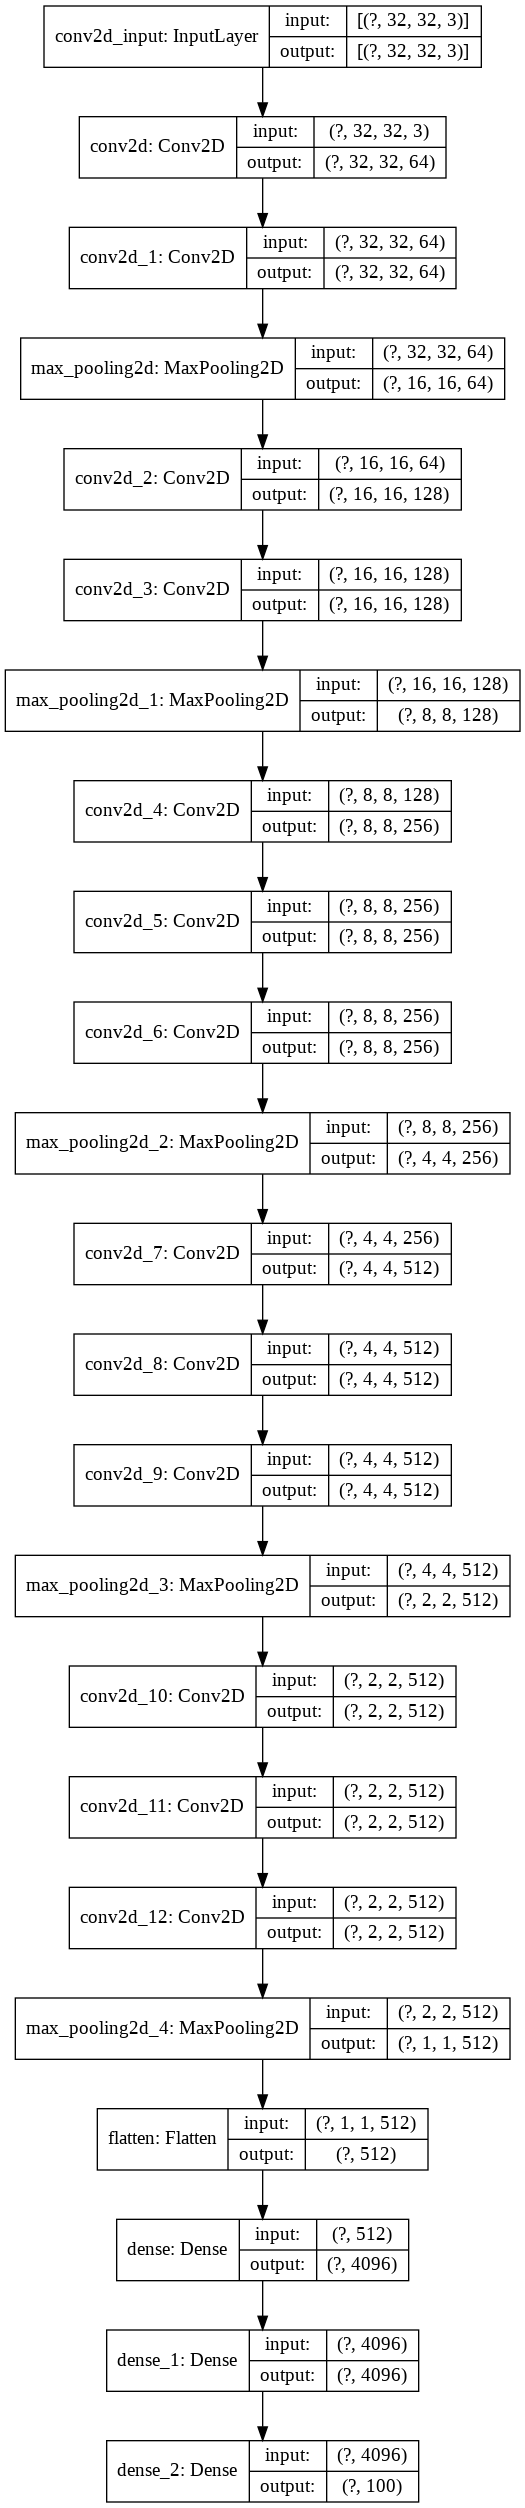

In [ ]:
from keras.utils import plot_model
plot_model(model, show_shapes = True, to_file = 'VGGNet16.png')

In [ ]:
datagen = ImageDataGenerator(
            rotation_range = 15,
            width_shift_range = 0.1,
            height_shift_range = 0.1,
            horizontal_flip = True)
datagen.fit(x_train)

In [ ]:
from keras.callbacks import ModelCheckpoint, EarlyStopping
checkpoint = ModelCheckpoint("vgg16_sgd1.h5", monitor = 'val_accuracy', verbose = 1, save_best_only = True, save_weights_only = False, mode = 'auto')
early = EarlyStopping(monitor = 'val_accuracy', min_delta = 0, patience = 20, verbose = 1, mode = 'auto')
hist = model.fit_generator(steps_per_epoch = x_train.shape[0] // batch_size, generator = datagen.flow(x_train, y_train1, batch_size = batch_size), validation_data = (x_val, y_val1), validation_steps = 10,epochs = 200,callbacks = [checkpoint, early])

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/200
390/390 [==============================] - ETA: 0s - loss: 4.2430 - accuracy: 0.0486WARNING:tensorflow:Callbacks method `on_test_batch_end` is slow compared to the batch time (batch time: 0.0072s vs `on_test_batch_end` time: 0.1398s). Check your callbacks.

Epoch 00001: val_accuracy improved from -inf to 0.08540, saving model to vgg16_sgd1.h5
390/390 [==============================] - 57s 147ms/step - loss: 4.2430 - accuracy: 0.0486 - val_loss: 3.9600 - val_accuracy: 0.0854
Epoch 2/200
390/390 [==============================] - ETA: 0s - loss: 3.6873 - accuracy: 0.1241
Epoch 00002: val_accuracy improved from 0.08540 to 0.15900, saving model to vgg16_sgd1.h5
390/390 [==============================] - 53s 136ms/step - loss: 3.6873 - accuracy: 0.1241 - val_loss: 3.5055 - val_accuracy: 0.1590
Epoch 3/200
390/390 [==============================] - ETA: 0s - loss: 3.2896 - accuracy: 0.1913
Epoch 00003: va

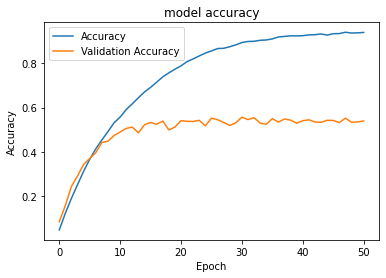

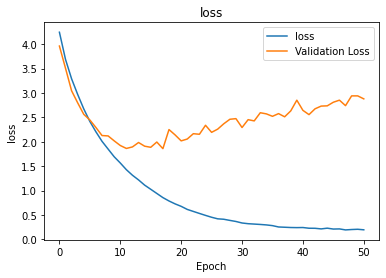

In [ ]:
import matplotlib.pyplot as plt
plt.figure(1)
plt.plot(hist.history["accuracy"])
plt.plot(hist.history['val_accuracy'])
plt.title("model accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["Accuracy","Validation Accuracy"])
plt.savefig('vgg16_sgd_acc.png')
plt.show()

plt.figure(2)
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title("loss")
plt.ylabel("loss")        
plt.xlabel("Epoch")
plt.legend(["loss","Validation Loss"])
plt.savefig('vgg16_sgd_loss.png')
plt.show()


### Evaluation of Model

In [ ]:
from keras.datasets import cifar100
import numpy as np
import keras

(x_train, y_train), (x_test, y_test) = cifar100.load_data()
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

def normalize(x):
    mean = np.mean(x, axis = (0, 1, 2, 3))
    std = np.std(x, axis = (0, 1, 2, 3))
    print(mean)
    print(std)
    x = (x - mean) / std
    return x

x_train = normalize(x_train)
x_test = normalize(x_test)

y_train1 = keras.utils.to_categorical(y_train, 100)
y_test1 = keras.utils.to_categorical(y_test, 100)

169009152/169001437 [==============================] - 4s 0us/step
121.93584
68.38902
122.241035
68.63058


In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from keras.models import load_model
import os

path = os.path.join(os.path.dirname(os.getcwd()), "weights\VGGNet16_SGD_NoRegularization.h5")
# path = '/content/drive/My Drive/weights/VGGNet16_SGD_NoRegularization.h5'
print(path)
model1 = load_model(path)

/content/drive/My Drive/weights/VGGNet16_SGD_NoRegularizatoin.h5


In [ ]:
_, accuracy = model1.evaluate(x_test, y_test1)

313/313 [==============================] - 3s 9ms/step - loss: 2.2727 - accuracy: 0.5611


In [ ]:
pred = model1.predict_classes(x_test)

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

cm = confusion_matrix(pred, y_test)
cr = classification_report(pred, y_test)

In [ ]:
print(cr)

              precision    recall  f1-score   support

           0       0.71      0.86      0.78        83
           1       0.55      0.69      0.61        80
           2       0.41      0.44      0.42        94
           3       0.20      0.29      0.24        69
           4       0.42      0.38      0.40       111
           5       0.55      0.73      0.63        75
           6       0.68      0.55      0.61       124
           7       0.60      0.54      0.57       112
           8       0.69      0.64      0.67       107
           9       0.63      0.71      0.67        89
          10       0.39      0.37      0.38       105
          11       0.28      0.55      0.37        51
          12       0.69      0.44      0.54       156
          13       0.62      0.44      0.51       141
          14       0.69      0.39      0.50       175
          15       0.51      0.55      0.53        93
          16       0.57      0.66      0.61        87
          17       0.61    

In [ ]:
np.set_printoptions(threshold = np.inf)
cm

array([[71,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  0,  0,  0,  0,  0,
         1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  5,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  2,  0,  0,  0,  0,  0,  0,  0,  0,  2,  0,  0,  0,
         0,  0,  0,  0],
       [ 0, 55,  0,  0,  0,  0,  1,  0,  0,  0,  2,  0,  0,  0,  1,  0,
         1,  0,  0,  0,  0,  0,  1,  0,  1,  0,  0,  1,  0,  1,  0,  0,
         1,  0,  0,  0,  0,  0,  0,  0,  2,  0,  1,  0,  0,  1,  0,  0,
         0,  0,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  0,  0,
         1,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  3,  0,  1,  0,  0,
         1,  0,  1,  0],
       [ 0,  0, 41,  1,  0,  0,  0,  0,  1,  2,  1, 10,  0,  0,  1,  0,
         0,  0